In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
from collections import defaultdict
import numpy as np
import pandas as pd
import crocoddyl
crocoddyl.switchToNumpyArray()
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 80

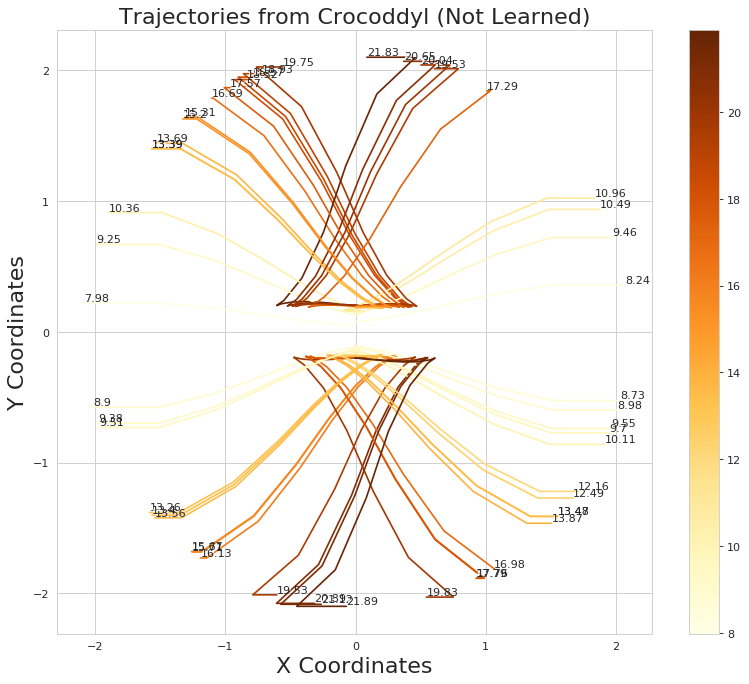

In [4]:
data = []
cost_dict = defaultdict()


def point(h, k, r):
    theta = random.random() * 2 * np.pi
    return h + np.cos(theta) * r, k + np.sin(theta) * r

for _ in range(50):
    x, y = point(0, 0, 2.1)
    
    initial_config = [x, y, 0]       

#for _ in range(20):
#    initial_config = [random.uniform(-1.99, 1.99), random.uniform(-1.99, 1.99), 0]            
    model = crocoddyl.ActionModelUnicycle()

    model.costWeights = np.matrix([1, 0.3]).T

    problem = crocoddyl.ShootingProblem(np.matrix(initial_config).T, [ model ] * 30, model)
    ddp = crocoddyl.SolverFDDP(problem)
    ddp.solve([], [], 1000)
    if ddp.iter < 1000:
        
        position = []
        # Attach x, y, theta
        position.extend(i for i in ddp.xs[0])
        # Attach linear_velocity, angular_velocty
        position.extend(i for i in ddp.us[0])
        # Attach cost
        position.append(sum(d.cost for d in ddp.datas()))
        # Attach the number of iterations
        position.append(ddp.iter)
        data.append(position)
        
        # Store the key = cost and value = trajectory(ie x, y) in dictionary 
        a = np.delete(np.array(ddp.xs), 2, 1)
        cost_dict[sum(d.cost for d in ddp.datas())] = a

data = np.array(data)
df = pd.DataFrame(data[0:,0:], columns = ["x_position", "y_position", "z_position", "linear_velocity", "angular_velocity", "value_function", "iterations"])
df = df.sample(frac=1).reset_index(drop=True)


c = cost_dict.keys()
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))
cmap = mpl.cm.ScalarMappable(norm = norm, cmap=mpl.cm.YlOrBr)
cmap.set_array([])

fig = plt.figure(figsize=(12, 10))
    
for key, trajectory in cost_dict.items():
    plt.scatter(trajectory[:, 0], trajectory[:, 1], marker = '', zorder=2, s=50,linewidths=0.2,alpha=.8, cmap = cmap )
    plt.plot(trajectory[:, 0], trajectory[:, 1], c=cmap.to_rgba(key))
    label = np.around(key, 2)
    plt.annotate(label, xy = (trajectory[0,0], trajectory[0,1]),
                    arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"),
                    horizontalalignment='left',
                    verticalalignment='bottom',)
    
plt.xlabel("X Coordinates", fontsize = 20)
plt.ylabel("Y Coordinates", fontsize = 20)
plt.title("Trajectories from Crocoddyl (Not Learned)", fontsize =20)

plt.colorbar(cmap)